In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class NeuralCA(nn.Module):
    def __init__(self, num_channels=16, grid_size=64):
        super(NeuralCA, self).__init__()
        self.num_channels = num_channels
        self.grid_size = grid_size
        
        # Define a convolutional layer to aggregate neighbor states
        self.perceive = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, bias=False)
        
        # Define a small network to update cell states
        self.update_fn = nn.Sequential(
            nn.Linear(num_channels, 128),
            nn.ReLU(),
            nn.Linear(128, num_channels),
            nn.Tanh()
        )
    
    def forward(self, x):
        # Perceive neighbors
        neighbor_states = self.perceive(x)
        
        # Update state for each cell
        batch_size, channels, height, width = x.size()
        neighbor_states_flat = neighbor_states.view(batch_size, channels, -1).permute(0, 2, 1)
        updated_states_flat = self.update_fn(neighbor_states_flat)
        
        # Reshape back to grid form
        updated_states = updated_states_flat.permute(0, 2, 1).view(batch_size, channels, height, width)
        
        # Combine old and new states
        return x + updated_states


In [4]:
def initialize_grid(batch_size, num_channels, grid_size):
    # Random grid initialization
    grid = torch.zeros(batch_size, num_channels, grid_size, grid_size)
    center = grid_size // 2
    grid[:, :, center, center] = 1.0  # Activate the center cell
    return grid


In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [12]:
# Configuration
num_channels = 16
grid_size = 64
batch_size = 8
steps_per_epoch = 16

# Initialize the NCA and optimizer
nca = NeuralCA(num_channels=num_channels, grid_size=grid_size)
nca.apply(init_weights)
optimizer = optim.Adam(nca.parameters(), lr=1e-5)

# Initialize the grid
grid = initialize_grid(batch_size, num_channels, grid_size)

# Loss function
def loss_fn(grid):
    # Example: Encourage cells to spread activation
    activation = grid[:, 0, :, :]  # Use the first channel as "activation"
    loss = -torch.mean(activation)
    return loss + 1e-4 * torch.sum(grid ** 2)  # Regularization

# Training loop
for epoch in range(200):  # 100 epochs
    optimizer.zero_grad()
    
    # Simulate multiple steps
    for _ in range(steps_per_epoch):
        grid = nca(grid)
        grid = grid.detach()  # Detach to avoid backprop through previous steps
        grid.requires_grad_()  # Re-enable gradient tracking for the next step
    
    # Compute loss
    loss = loss_fn(grid)
    loss.backward()
    optimizer.step()
    
    # Display progress
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 2.976834535598755
Epoch 10, Loss: 386014.1875
Epoch 20, Loss: 2655484.75
Epoch 30, Loss: 7016797.0
Epoch 40, Loss: 13472422.0
Epoch 50, Loss: 22037776.0
Epoch 60, Loss: 32703730.0
Epoch 70, Loss: 45472532.0
Epoch 80, Loss: 60344516.0
Epoch 90, Loss: 77336064.0
Epoch 100, Loss: 96432696.0
Epoch 110, Loss: 117610280.0
Epoch 120, Loss: 140851840.0
Epoch 130, Loss: 166207312.0
Epoch 140, Loss: 193665456.0
Epoch 150, Loss: 223214576.0
Epoch 160, Loss: 254867936.0
Epoch 170, Loss: 288609312.0
Epoch 180, Loss: 324391264.0
Epoch 190, Loss: 362258432.0


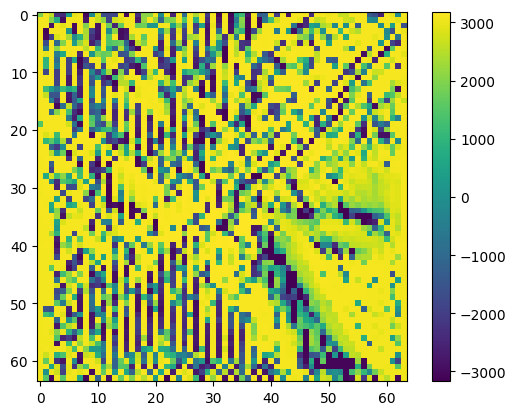

In [13]:
# Visualize the grid
def visualize_grid(grid):
    activation = grid[0, 0].detach().cpu().numpy()  # Visualize first batch, first channel
    plt.imshow(activation, cmap="viridis")
    plt.colorbar()
    plt.show()

visualize_grid(grid)
